In [1]:
import numpy as np
from astropy.table import Table, Column
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from edge_pydb import EdgeTable
from edge_pydb.conversion import msd_co
from edge_pydb.plotting import xy2hist, xy2binned
np.seterr(invalid='ignore')
plt.rcParams["scatter.edgecolors"] = 'none'

## Spatially resolved SF relations for EDGE, at 7" resolution (not deprojected)
### For CO, we use the 'smo' mask for detections but the 'str' mask for considering non-detections.  These differ in velocity width so we scale the 'str' mask noise down to the median velocity width for the 'smo' mask.
### For SFR, we load the extinction uncorrected values, as well as the pixel-wise Balmer decrement corrected values, and the "adopted" values where the extinction is calculated after smoothing the H$\alpha$ and H$\beta$ images.

In [2]:
# limit the columns we read to avoid information overload
sspcols = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']
fluxcols = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm','e_flux_Hbeta_sm',
            'flux_sigsfr0_sm','flux_sigsfr_corr_sm','flux_sigsfr_adopt_sm','EW_Halpha_sm']
comomcols = ['Name','ix','iy','mom0_12','emom0_12','sigmol']

# Note that NGC 5784 is missing stellar mass
globaltab = EdgeTable('edge_califa.csv', cols=['Name','caMass'])
cofluxtab = EdgeTable('edge_coflux_smo7.csv', cols=['Name','coNomaskDv_smo7','coSmoothDv_smo7'])
try: 
    fluxtab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo', cols=comomcols)
    conomasktab = EdgeTable('edge.comom_smo7.hdf5', path='str', cols=['Name','ix','iy','emom0_12'])
    print('Working on full EDGE database')
except:
    fluxtab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm', cols=fluxcols)
    ssptab = EdgeTable('NGC4047.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo', cols=comomcols)
    conomasktab = EdgeTable('NGC4047.comom_smo7.hdf5', path='str', cols=['Name','ix','iy','emom0_12'])
    print('Working on NGC 4047 data')

Working on full EDGE database


In [3]:
print('Median unmasked velocity width is',np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Median masked velocity width is',np.nanmedian(cofluxtab['coSmoothDv_smo7']))
nsefactor = np.sqrt(np.nanmedian(cofluxtab['coSmoothDv_smo7'])/np.nanmedian(cofluxtab['coNomaskDv_smo7']))
print('Noise estimates will be scaled down by',nsefactor)

Median unmasked velocity width is 860.0
Median masked velocity width is 420.0
Noise estimates will be scaled down by 0.6988362419217079


In [4]:
# consolidate the tables
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
conomasktab['emom0_12'] *= nsefactor
conomasktab['emom0_12'].name = 'emom0max_12'
fluxtab.join(conomasktab, keys=['Name', 'ix', 'iy'])
fluxtab.join(globaltab)
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'e_flux_Hbeta_sm', 'flux_sigsfr0_sm', 'flux_sigsfr_corr_sm', 'flux_sigsfr_adopt_sm', 'EW_Halpha_sm', 'mass_ssp_sm', 'sigstar_sm', 'mom0_12', 'emom0_12', 'sigmol', 'emom0max_12', 'caMass']


In [5]:
# Apply a 3-sigma cut to CO and Halpha
codet = fluxtab['mom0_12'] > 3*fluxtab['emom0_12']
sfdet = fluxtab['flux_Halpha_sm'] > 3*fluxtab['e_flux_Halpha_sm']
det = codet & sfdet
ndet = ~codet & sfdet

In [6]:
sfe_det = Table()
sfe_det['Name'] = fluxtab['Name'][det]
sfe_det['ICO'] = fluxtab['mom0_12'][det]
sfe_det['IHA'] = fluxtab['flux_Halpha_sm'][det]
sfe_det['sigmol'] = fluxtab['sigmol'][det]
sfe_det['sigsfr'] = fluxtab['flux_sigsfr_adopt_sm'][det]
sfe_det['sigsfr_cor'] = fluxtab['flux_sigsfr_corr_sm'][det]
sfe_det['sigsfr0'] = fluxtab['flux_sigsfr0_sm'][det]
sfe_det['sigstar'] = fluxtab['sigstar_sm'][det]
sfe_det['stmass'] = fluxtab['caMass'][det]
sfe_det['haew'] = abs(fluxtab['EW_Halpha_sm'][det])
sfe_det['t_dep'] = Column(sfe_det['sigmol'].quantity/sfe_det['sigsfr'].quantity)
sfe_det['sigssfr'] = Column(sfe_det['sigsfr'].quantity/sfe_det['sigstar'].quantity)
sfe_det

Name,ICO,IHA,sigmol,sigsfr,sigsfr_cor,sigsfr0,sigstar,stmass,haew,t_dep,sigssfr
,K km / s,1e-16 erg / (cm2 s),solMass / pc2,solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / pc2,dex(solMass),Angstrom,Gyr,1 / Gyr
str16,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32
ARP220,4.222969,0.2655836,18.158768,6.642868,3.4479165,1.1125973,44.857906,10.9099,10.386424,2.7335734,0.14808689
ARP220,11.10943,0.34287092,47.770554,1.436386,12.304999,1.436386,40.720436,10.9099,15.397308,33.25746,0.035274327
ARP220,10.225425,0.28539938,43.96933,1.1955881,nan,1.1955881,52.427483,10.9099,14.497993,36.776318,0.022804607
ARP220,4.9249167,0.1637056,21.177143,0.68578005,nan,0.68578005,42.722446,10.9099,10.357886,30.880373,0.016051985
ARP220,4.680669,0.31773764,20.126877,5.9548984,2.6177208,1.3310866,43.924126,10.9099,12.699126,3.379886,0.13557239
ARP220,7.8781853,0.31534946,33.876198,1.3210392,6.6359797,1.3210392,41.05472,10.9099,14.049808,25.643599,0.032177523
ARP220,8.267964,0.23644416,35.55225,0.99049556,nan,0.99049556,53.458893,10.9099,11.779383,35.8934,0.018528173
ARP220,3.382165,0.12021709,14.54331,0.5036206,2.7286768,0.5036206,19.98299,10.9099,8.050527,28.877512,0.025202466


In [7]:
sfe_ndet = Table()
sfe_ndet['Name'] = fluxtab['Name'][ndet]
sfe_ndet['sigmol'] = msd_co(3*fluxtab['emom0max_12'][ndet])
sfe_ndet['sigsfr'] = fluxtab['flux_sigsfr_adopt_sm'][ndet]
sfe_ndet['sigsfr_cor'] = fluxtab['flux_sigsfr_corr_sm'][ndet]
sfe_ndet['sigsfr0'] = fluxtab['flux_sigsfr0_sm'][ndet]
sfe_ndet['sigstar'] = fluxtab['sigstar_sm'][ndet]
sfe_ndet['stmass'] = fluxtab['caMass'][ndet]
sfe_ndet['haew'] = abs(fluxtab['EW_Halpha_sm'][ndet])
sfe_ndet['t_dep'] = Column(sfe_ndet['sigmol'].quantity/sfe_ndet['sigsfr'].quantity)
sfe_ndet['sigssfr'] = Column(sfe_ndet['sigsfr'].quantity/sfe_ndet['sigstar'].quantity)
sfe_ndet

Name,sigmol,sigsfr,sigsfr_cor,sigsfr0,sigstar,stmass,haew,t_dep,sigssfr
,solMass / pc2,solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / pc2,dex(solMass),Angstrom,Gyr,1 / Gyr
str16,float32,float32,float32,float32,float32,float64,float32,float32,float32
ARP220,29.864283,0.7160927,nan,0.7160927,46.765747,10.9099,7.7226133,41.70449,0.015312334
ARP220,29.076519,1.197291,22.726385,1.197291,61.743862,10.9099,10.522485,24.285255,0.019391255
ARP220,28.891478,6.516649,5.0440326,0.9784045,63.75594,10.9099,8.3239565,4.433487,0.10221242
ARP220,28.839254,4.930127,1.9837341,0.9093213,62.863316,10.9099,7.8415546,5.8495965,0.07842614
ARP220,30.622854,0.27962524,nan,0.27962524,35.264164,10.9099,5.114726,109.513916,0.007929444
ARP220,29.398457,1.2979357,4124.414,1.2979357,72.26009,10.9099,12.3468485,22.650164,0.017962
ARP220,29.884035,5.1755095,1.4028893,1.0138828,45.494026,10.9099,9.33276,5.774124,0.11376239
ARP220,29.827902,4.4946775,1.1367159,1.1051044,45.53727,10.9099,10.162628,6.636272,0.09870327


## Spatially resolved CO vs. Halpha

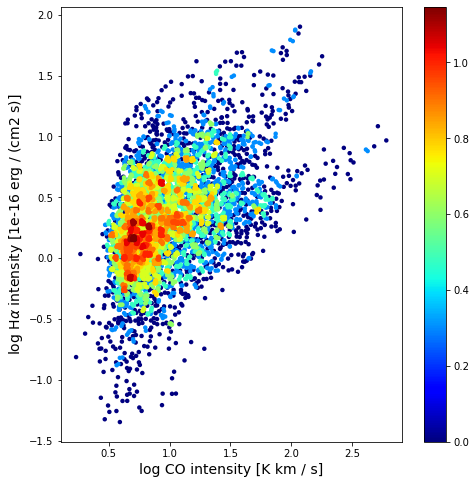

In [8]:
# Make the scatter plot (measured values)
x_det, y_det, z_det, *hist = xy2hist(sfe_det['ICO'], sfe_det['IHA'], log=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, cmap='jet')
plt.xlabel('log CO intensity ['+str(sfe_det['ICO'].unit)+']',fontsize=14)
plt.ylabel(r'log H$\alpha$ intensity ['+str(sfe_det['IHA'].unit)+']',fontsize=14)
cb = plt.colorbar(sc)

## Spatially resolved star formation law (compare extinction corrections)

==CO Detections==
Number of valid, invalid values: 5322 0
==Non-detections==
Number of valid, invalid values: 25167 0
==CO Detections==
Number of valid, invalid values: 5310 12
==Non-detections==
Number of valid, invalid values: 24572 595
==CO Detections==
Number of valid, invalid values: 5322 0
==Non-detections==
Number of valid, invalid values: 25167 0


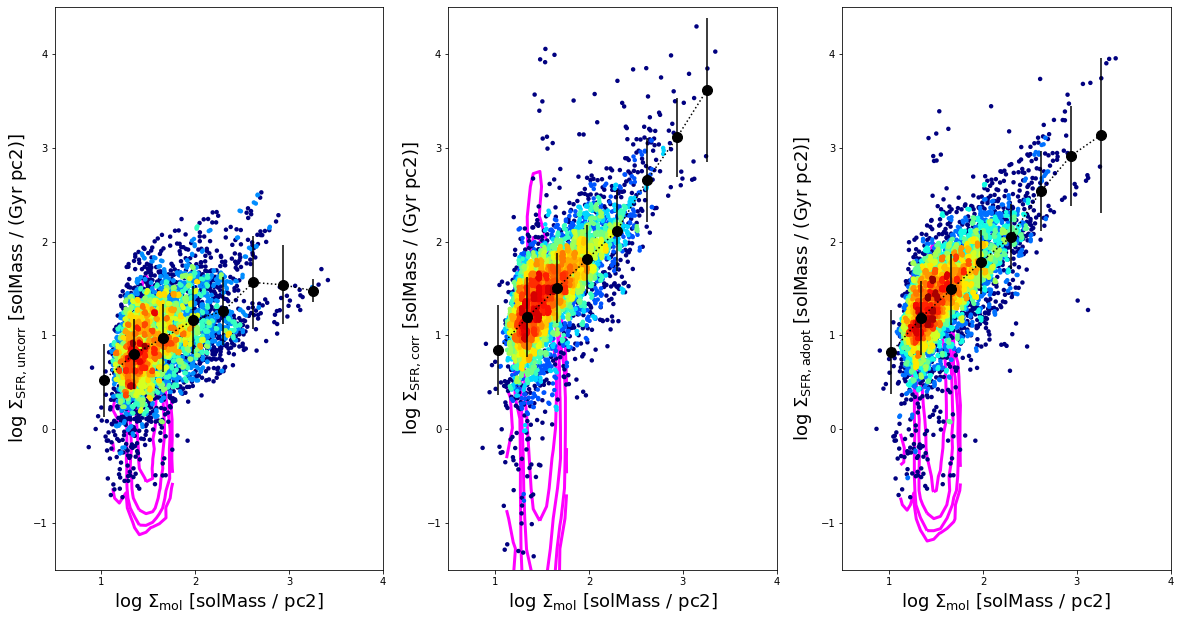

In [9]:
fig, axarr = plt.subplots(1, 3, figsize=(20,12))
ylbl = ['uncorr', 'corr', 'adopt']

for i, sfrcol in enumerate(['sigsfr0','sigsfr_cor','sigsfr']):
    # Select data to plot (must be loggable)
    valid = (sfe_det['sigmol'] > 0) & (sfe_det[sfrcol] > 0)
    print('==CO Detections==')
    print('Number of valid, invalid values:',len(np.nonzero(valid)[0]),len(np.nonzero(~valid)[0]))
    valid_ndet = (sfe_ndet['sigmol'] > 0) & (sfe_ndet[sfrcol] > 0)
    print('==Non-detections==')
    print('Number of valid, invalid values:',len(np.nonzero(valid_ndet)[0]),len(np.nonzero(~valid_ndet)[0]))

    # Get the plotting arrays
    x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigmol'][valid], 
                                         sfe_det[sfrcol][valid], log=True)
    x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sfe_ndet['sigmol'][valid_ndet], 
                                             sfe_ndet[sfrcol][valid_ndet], log=True, bins=[10,30])

    # Make the scatter plot (physical values)
    sc = axarr[i].scatter(x_det, y_det, c=z_det, s=20, cmap='jet')
    x_bin, y_bin, y_err = xy2binned(sfe_det['sigmol'][valid], sfe_det[sfrcol][valid], bins=8)
    axarr[i].errorbar(x_bin, y_bin, yerr=y_err, color='k', marker='o', ms=10, ls=':', label='all')
    axarr[i].contour(hist2[0].transpose(),[10,30,100,300],
               extent=[hist2[1].min(),hist2[1].max(),
                       hist2[2].min(),hist2[2].max()],
               colors='magenta',linewidths=3,zorder=-1)
    axarr[i].set_xlabel(r'log $\Sigma_{\rm mol}$ ['+str(sfe_det['sigmol'].unit)+']',fontsize=18)
    axarr[i].set_ylabel(r'log $\Sigma_{\rm SFR,'+ylbl[i]+'}$ ['+str(sfe_det[sfrcol].unit)+']',fontsize=18)
    axarr[i].set_aspect('equal')
    axarr[i].set_xlim(0.5,4)
    axarr[i].set_ylim(-1.5,4.5)
    axarr[i].xaxis.set_major_locator(MultipleLocator(1))
    axarr[i].yaxis.set_major_locator(MultipleLocator(1))

## SF Law separated by stellar mass [cf. Fig. 17(a) of Bolatto+17]

Points from high-mass galaxies: 3004
Points from low-mass galaxies: 2281


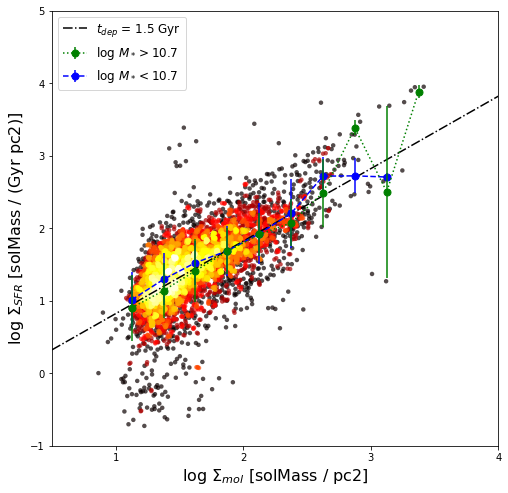

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
xlims=[0.5, 4]
x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigmol'][valid], 
                                     sfe_det['sigsfr'][valid], log=True)
ax.scatter(x_det, y_det, c=z_det, s=20, cmap='hot', alpha=0.7)

valid = (sfe_det['sigmol'] > 0) & (sfe_det['sigsfr'] > 0)
himass = valid & (sfe_det['stmass'] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = valid & (sfe_det['stmass'] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det['sigmol'][himass], 
                                      sfe_det['sigsfr'][himass], bins=10, range=[1,3.5])
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det['sigmol'][lomass], 
                                      sfe_det['sigsfr'][lomass], bins=10, range=[1,3.5])
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

# 1.5 Gyr depletion time
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - np.log10(1.5)
ax.plot(xmod, ymod, ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')

ax.set_xlabel(r'log $\Sigma_{mol}$ ['+str(sfe_det['sigmol'].unit)+']',fontsize=16)
ax.set_ylabel(r'log $\Sigma_{SFR}$ ['+str(sfe_det['sigsfr'].unit)+']',fontsize=16)
ax.set_xlim(xlims)
ax.set_ylim(-1,5)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

## Depletion time vs. local stellar density or sSFR

==CO Detections==
Number of valid, invalid values: 5321 1
Points from high-mass galaxies: 3003
Points from low-mass galaxies: 2281
==Non-detections==
Number of valid, invalid values: 23058 2109
==CO Detections==
Number of valid, invalid values: 5321 1
Points from high-mass galaxies: 3003
Points from low-mass galaxies: 2281
==Non-detections==
Number of valid, invalid values: 23058 2109


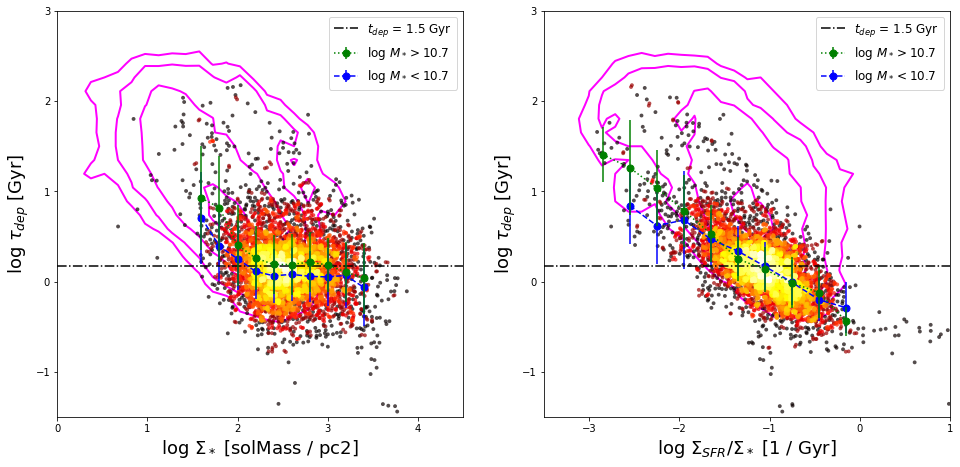

In [11]:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
xlbl = ['$\Sigma_*$', '$\Sigma_{SFR}$/$\Sigma_*$']
xbinlim = [[1.5,3.5], [-3,0]]
for i, starcol in enumerate(['sigstar','sigssfr']):

    # Select data to plot (must be loggable)
    sstd_valid = ~np.isnan(sfe_det[starcol]) & (sfe_det[starcol]>0) & (sfe_det['t_dep']>0)
    print('==CO Detections==')
    print('Number of valid, invalid values:',len(np.nonzero(sstd_valid)[0]),len(np.nonzero(~sstd_valid)[0]))
    himass = sstd_valid & (sfe_det['stmass'] > 10.7)
    print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
    lomass = sstd_valid & (sfe_det['stmass'] <= 10.7)
    print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))
    sstd_valid_ndet = ~np.isnan(sfe_ndet[starcol]) & (sfe_ndet[starcol]>0) & (sfe_ndet['t_dep']>0)
    print('==Non-detections==')
    print('Number of valid, invalid values:',len(np.nonzero(sstd_valid_ndet)[0]),
          len(np.nonzero(~sstd_valid_ndet)[0]))

    x_det, y_det, z_det, *hist = xy2hist(sfe_det[starcol][sstd_valid], 
                                         sfe_det['t_dep'][sstd_valid], log=True)
    x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sfe_ndet[starcol][sstd_valid_ndet], 
                                             sfe_ndet['t_dep'][sstd_valid_ndet], 
                                             log=True, bins=[30,30])

    xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det[starcol][himass], 
                                          sfe_det['t_dep'][himass], bins=10, range=xbinlim[i])
    xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det[starcol][lomass], 
                                          sfe_det['t_dep'][lomass], bins=10, range=xbinlim[i])

    # Make the scatter plot
    axarr[i].scatter(x_det, y_det, c=z_det, s=15, cmap='hot', alpha=0.7)
    axarr[i].errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
                color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
    axarr[i].errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
                color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
    axarr[i].contour(hist2[0].transpose(),[10,30,100,300],
               extent=[hist2[1].min(),hist2[1].max(),
                       hist2[2].min(),hist2[2].max()],
               colors='magenta',linewidths=2,zorder=-1)
    axarr[i].set_xlabel(r'log '+xlbl[i]+' ['+str(sfe_det[starcol].unit)+']',fontsize=18)
    axarr[i].set_ylabel(r'log $\tau_{dep}$ ['+str(sfe_det['t_dep'].unit)+']',fontsize=18)
    axarr[i].set_aspect('equal')
    axarr[i].axhline(np.log10(1.5), ls='-.', color='k', label='$t_{dep}$ = 1.5 Gyr')
    if i == 0:
        axarr[i].set_xlim(0,4.5)
    else:
        axarr[i].set_xlim(-3.5,1)
    axarr[i].set_ylim(-1.5,3)
    axarr[i].xaxis.set_major_locator(MultipleLocator(1))
    axarr[i].yaxis.set_major_locator(MultipleLocator(1))
    axarr[i].legend(fontsize='large')

## H$\alpha$ equivalent width vs. local sSFR

==CO Detections==
Number of valid, invalid values: 5321 1
Points from high-mass galaxies: 3003
Points from low-mass galaxies: 2281


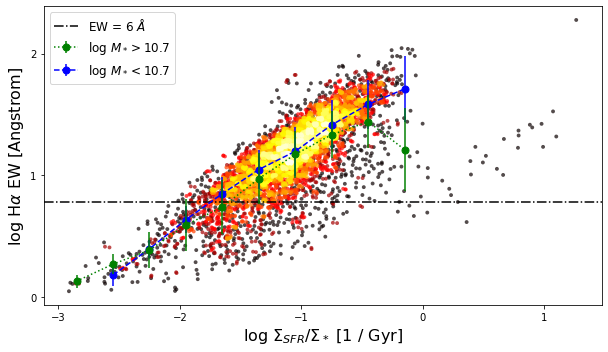

In [12]:
# Select data to plot (must be loggable)
ewvalid = ~np.isnan(sfe_det['sigssfr']) & (sfe_det['sigssfr']>0) & (sfe_det['haew']>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(ewvalid)[0]),len(np.nonzero(~ewvalid)[0]))
himass = ewvalid & (sfe_det['stmass'] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = ewvalid & (sfe_det['stmass'] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

x_det, y_det, z_det, *hist = xy2hist(sfe_det['sigssfr'][ewvalid], 
                                     sfe_det['haew'][ewvalid], log=True)

xhi_bin, yhi_bin, yhi_err = xy2binned(sfe_det['sigssfr'][himass], 
                                      sfe_det['haew'][himass], bins=10, range=[-3,0])
xlo_bin, ylo_bin, ylo_err = xy2binned(sfe_det['sigssfr'][lomass], 
                                      sfe_det['haew'][lomass], bins=10, range=[-3,0])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x_det, y_det, c=z_det, s=15, cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')

ax.set_xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(sfe_det['sigssfr'].unit)+']',fontsize=16)
ax.set_ylabel(r'log H$\alpha$ EW ['+str(sfe_det['haew'].unit)+']',fontsize=16)
ax.set_aspect('equal')
ax.axhline(np.log10(6), ls='-.', color='k', label='EW = 6 $\AA$')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.legend(fontsize='large')

## H$_2$ vs. stellar surface density relation.  Here we select only on CO detection, ignoring H$\alpha$.

==CO Detections==
Number of valid, invalid values: 5342 317
Points from high-mass galaxies: 3011
Points from low-mass galaxies: 2294
==Non-detections==
Number of valid, invalid values: 27875 158762


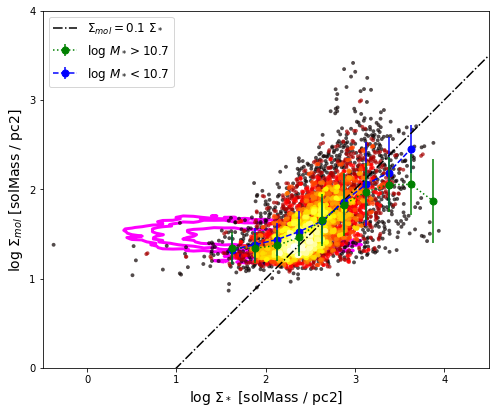

In [13]:
sigmol = fluxtab['sigmol'][codet]
sigstar = fluxtab['sigstar_sm'][codet]
h2s_valid = ~np.isnan(sigstar) & (sigmol>0) & (sigstar>0)
print('==CO Detections==')
print('Number of valid, invalid values:',len(np.nonzero(h2s_valid)[0]),len(np.nonzero(~h2s_valid)[0]))
himass = h2s_valid & (fluxtab['caMass'][codet] > 10.7)
print('Points from high-mass galaxies:',len(np.nonzero(himass)[0]))
lomass = h2s_valid & (fluxtab['caMass'][codet] <= 10.7)
print('Points from low-mass galaxies:',len(np.nonzero(lomass)[0]))

sigmol_nd = msd_co(3*fluxtab['emom0max_12'][~codet])
sigstar_nd = fluxtab['sigstar_sm'][~codet]

h2s_valid_ndet = ~np.isnan(sigstar_nd) & (sigmol_nd>0) & (sigstar_nd>0)
print('==Non-detections==')
print('Number of valid, invalid values:',len(np.nonzero(h2s_valid_ndet)[0]),len(np.nonzero(~h2s_valid_ndet)[0]))

x_det, y_det, z_det, *hist = xy2hist(sigstar[h2s_valid], 
                                     sigmol[h2s_valid], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sigstar_nd[h2s_valid_ndet], 
                                         sigmol_nd[h2s_valid_ndet], 
                                         log=True, bins=[40,40])

xhi_bin, yhi_bin, yhi_err = xy2binned(sigstar[himass], 
                                      sigmol[himass], bins=10, range=[1.5,4])
xlo_bin, ylo_bin, ylo_err = xy2binned(sigstar[lomass], 
                                      sigmol[lomass], bins=10, range=[1.5,4])

# Make the scatter plot
fig, ax = plt.subplots(figsize=(8,8))
xlims = [-0.5,4.5]
ax.scatter(x_det, y_det, c=z_det, s=15, cmap='hot', alpha=0.7)
ax.errorbar(xhi_bin, yhi_bin, yerr=yhi_err, zorder=3,
            color='green', marker='o', ms=7, ls=':', label='log $M_*>10.7$')
ax.errorbar(xlo_bin, ylo_bin, yerr=ylo_err, zorder=2,
            color='blue', marker='o', ms=7, ls='--', label='log $M_*<10.7$')
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
ax.set_xlabel(r'log $\Sigma_*$ ['+str(sigmol.unit)+']',fontsize=14)
ax.set_ylabel(r'log $\Sigma_{mol}$ ['+str(sigstar.unit)+']',fontsize=14)
ax.set_aspect('equal')
xmod = np.linspace(xlims[0], xlims[1], num=10)
ymod = xmod - 1
ax.plot(xmod, ymod, ls='-.', color='k', label='$\Sigma_{mol}=0.1\ \Sigma_*$')
ax.set_xlim(xlims)
ax.set_ylim(0,4)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend(fontsize='large')

## Identify which galaxies contribute the most pixels to the plot.

In [14]:
import pandas as pd
galname=fluxtab['Name'][codet]
df = pd.DataFrame(galname[h2s_valid])
pd.set_option('display.max_rows', 1001)
df2 = df['Name'].value_counts().to_frame()
print(df2)

              Name
NGC2253        140
NGC6060        135
NGC5908        124
NGC6361        118
NGC5480        114
NGC4047        112
NGC5218        107
NGC6301        100
NGC5980         99
NGC2639         97
NGC6478         94
UGC04132        94
NGC5633         93
NGC5614         89
NGC2906         87
NGC6155         85
NGC2347         84
NGC5953         81
ARP220          78
IC4566          75
NGC2410         74
NGC6186         73
NGC0523         73
UGC05111        71
IC2247          70
IC0944          69
NGC5406         68
NGC0551         67
UGC10123        66
NGC5016         66
NGC3811         62
UGC08107        59
NGC4210         59
NGC6004         58
IC0480          56
IC2487          55
NGC5520         55
NGC4711         54
UGC09665        53
UGC04029        53
IC1199          51
NGC5056         50
UGC09476        49
NGC3994         49
NGC0477         49
UGC10043        48
UGC10384        47
NGC3815         47
NGC4644         47
UGC03973        45
IC5376          45
NGC5394     